# Phase 2: Statistical Analysis of EEG Data

## Objective
Perform comprehensive statistical analysis of the EEG dataset including:
1. Frequency domain analysis (FFT, Power Spectral Density)
2. EEG frequency band extraction (Delta, Theta, Alpha, Beta, Gamma)
3. Channel correlation analysis
4. Feature extraction for synthetic generation

This analysis will guide the synthetic data generation approach based on the methods from recent literature.


## 2.0. Paths & setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import signal, stats
import pickle
import warnings
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
OUTPUT_DIR = Path("../output/band_extraction")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## 2.1. Band power mapping with sampling rate

In [2]:
DATA_PATH = Path.home() / '.cache/kagglehub/datasets/nnair25/Alcoholics/versions/1'
TRAIN_PATH = DATA_PATH / 'SMNI_CMI_TRAIN'
TEST_PATH  = DATA_PATH / 'SMNI_CMI_TEST'

In [3]:
SAMPLING_RATE = 256  # Hz

# Canonical EEG frequency bands from human EEG literature
# (e.g., Niedermeyer & da Silva, "Electroencephalography", 5th ed.;
# Nunez & Srinivasan, "Electric Fields of the Brain", 2nd ed.)
# These are NOT data-driven for this dataset; we keep them fixed
# so our analyses are physiologically interpretable and comparable.

FREQUENCY_BANDS = {
    'Delta': (0.5, 4),    # Slow-wave activity
    'Theta': (4, 8),      # Drowsiness / early sleep, some cognitive tasks
    'Alpha': (8, 13),     # Classic posterior dominant rhythm (eyes closed)
    'Beta' : (13, 30),    # Faster activity, motor/cognitive
    'Gamma': (30, 50)     # Higher-frequency; we cap at 50 Hz to avoid EMG/noise
}

In [4]:
print(f"Sampling rate: {SAMPLING_RATE} Hz")
print("Bands:")
for band, (lo, hi) in FREQUENCY_BANDS.items():
    print(f"{band}: {lo}-{hi} Hz")

Sampling rate: 256 Hz
Bands:
Delta: 0.5-4 Hz
Theta: 4-8 Hz
Alpha: 8-13 Hz
Beta: 13-30 Hz
Gamma: 30-50 Hz


In [5]:
BAND_DEFINITION_META = {
    "nyquist_hz": SAMPLING_RATE / 2,
    "band_source": "Canonical EEG bands widely used in human EEG research, "
                   "not estimated from this dataset.",
    "notes": (
        "Bands are kept fixed (0.5–4, 4–8, 8–13, 13–30, 30–50 Hz) to allow "
        "interpretation as Delta/Theta/Alpha/Beta/Gamma and comparison "
        "with existing EEG literature."
    )
}
print("Band definition meta:")
for k, v in BAND_DEFINITION_META.items():
    print(f"  {k}: {v}")

Band definition meta:
  nyquist_hz: 128.0
  band_source: Canonical EEG bands widely used in human EEG research, not estimated from this dataset.
  notes: Bands are kept fixed (0.5–4, 4–8, 8–13, 13–30, 30–50 Hz) to allow interpretation as Delta/Theta/Alpha/Beta/Gamma and comparison with existing EEG literature.


## 2.2. Band Power Extraction from full dataset

### 2.2.1. Import path and constants for extraction from train & test files

In [6]:
train_files = sorted(TRAIN_PATH.glob("*.csv"))
test_files = sorted(TEST_PATH.glob("*.csv"))

file_records = []
for fp in train_files:
    file_records.append({"path": fp, "split": "train"})
for fp in test_files:
    file_records.append({"path": fp, "split": "test"})

print(f"Train files: {len(train_files)}")
print(f"Test files: {len(test_files)}")
print(f"Total files: {len(file_records)}")


Train files: 468
Test files: 480
Total files: 948


In [7]:
print("First 5 train files:")
for fp in train_files[:5]:
    print("  ", fp.name)
print("First 5 test files:")
for fp in test_files[:5]:
    print("  ", fp.name)

First 5 train files:
   Data1.csv
   Data10.csv
   Data100.csv
   Data101.csv
   Data102.csv
First 5 test files:
   Data1.csv
   Data10.csv
   Data100.csv
   Data101.csv
   Data102.csv


### 2.2.2. Quick Glance at one file structure

In [8]:
example_fp = train_files[0]
print("Example file:", example_fp.name)

Example file: Data1.csv


In [9]:
df_example = pd.read_csv(example_fp)
display(df_example.head())

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [10]:
print("Columns:", df_example.columns.tolist())
print("Unique subject identifier:", df_example["subject identifier"].unique())
print("Unique sensor positions:", df_example["sensor position"].unique()[:10])
print("Unique trial numbers:", df_example["trial number"].unique())

Columns: ['Unnamed: 0', 'trial number', 'sensor position', 'sample num', 'sensor value', 'subject identifier', 'matching condition', 'channel', 'name', 'time']
Unique subject identifier: ['a']
Unique sensor positions: ['FP1' 'FP2' 'F7' 'F8' 'AF1' 'AF2' 'FZ' 'F4' 'F3' 'FC6']
Unique trial numbers: [0]


### 2.2.3. Initialize accumulators and settings

In [11]:
all_features = []
failed_files = []
min_len = 100 

print("min_len (for trial length):", min_len)
print("Number of file records to process:", len(file_records))

min_len (for trial length): 100
Number of file records to process: 948


### 2.2.4. Extraction loop

#### 2.2.4.1. Compute PSD and band power

In [12]:
def compute_psd(signal_values, fs=SAMPLING_RATE):
    freqs, psd = signal.welch(
        signal_values,
        fs=fs,
        nperseg=min(256, len(signal_values))
    )
    return freqs, psd

def extract_band_power_from_psd(freqs, psd, bands=FREQUENCY_BANDS):
    band_powers = {}
    for band_name, (low_freq, high_freq) in bands.items():
        idx = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        if not np.any(idx):
            band_powers[band_name] = np.nan
        else:
            band_powers[band_name] = np.trapz(psd[idx], freqs[idx])
    return band_powers

#### 2.2.4.2 Process a single file to list of feature dicts

In [13]:
def process_file_for_band_power(fp: Path, split: str, min_len: int = 100):
    df = pd.read_csv(fp)

    # Subject type: 'a' or 'c'
    subj_types_in_file = df["subject identifier"].unique()
    if len(subj_types_in_file) != 1:
        print(f"[WARN] Multiple subject identifiers in file {fp.name}: {subj_types_in_file}")
    subject_type = subj_types_in_file[0]

    subject_id = df["name"].iloc[0]  # name of the subject
    channels = df["sensor position"].unique()
    trials = df["trial number"].unique()

    records = []

    for ch in channels:
        for tr in trials:
            trial_data = (
                df[(df["sensor position"] == ch) &
                   (df["trial number"] == tr)]
                .sort_values("sample num")
            )

            if len(trial_data) < min_len:
                continue

            # Extract matching condition
            mc_values = trial_data["matching condition"].unique()
            if len(mc_values) == 1:
                match_cond = mc_values[0]
            else:
                match_cond = trial_data["matching condition"].mode().iloc[0]

            signal_values = trial_data["sensor value"].values

            freqs, psd = compute_psd(signal_values, fs=SAMPLING_RATE)
            band_powers = extract_band_power_from_psd(freqs, psd)
            total_power = sum(v for v in band_powers.values() if pd.notnull(v))

            record = {
                "dataset_split": split,
                "file_name": fp.name,
                "subject_type": subject_type,
                "subject_id": subject_id,
                "channel": ch,
                "trial": tr,
                "matching_condition": match_cond,    # <── IMPORTANT
                **band_powers,
                "total_power": total_power,
            }

            records.append(record)

    return records

In [14]:
for i, rec in enumerate(file_records, start=1):
    fp = rec["path"]
    split = rec["split"]

    try:
        file_records_list = process_file_for_band_power(fp, split=split, min_len=min_len)
        all_features.extend(file_records_list)
    except Exception as e:
        print(f"[WARN] Failed on file {fp.name}: {e}")
        failed_files.append(fp.name)

    # Simple progress update every 50 files
    if i % 50 == 0 or i == len(file_records):
        print(f"Processed {i}/{len(file_records)} files "
              f"(current total segments={len(all_features)})")

print("Feature extraction results:")
print("Total segments collected:", len(all_features))

Processed 50/948 files (current total segments=3200)
Processed 100/948 files (current total segments=6400)
Processed 150/948 files (current total segments=9600)
Processed 200/948 files (current total segments=12800)
Processed 250/948 files (current total segments=16000)
Processed 300/948 files (current total segments=19200)
Processed 350/948 files (current total segments=22400)
Processed 400/948 files (current total segments=25600)
Processed 450/948 files (current total segments=28800)
Processed 500/948 files (current total segments=32000)
Processed 550/948 files (current total segments=35200)
Processed 600/948 files (current total segments=38400)
Processed 650/948 files (current total segments=41600)
Processed 700/948 files (current total segments=44800)
Processed 750/948 files (current total segments=48000)
Processed 800/948 files (current total segments=51200)
Processed 850/948 files (current total segments=54400)
Processed 900/948 files (current total segments=57600)
Processed 948/

#### 2.2.4.3. Extraction Summary

In [15]:
features_df = pd.DataFrame(all_features)
print("features_df shape:", features_df.shape)

features_df shape: (60672, 13)


In [16]:
features_df.head()

,dataset_split,file_name,subject_type,subject_id,channel,trial,matching_condition,Delta,Theta,Alpha,Beta,Gamma,total_power
0,train,Data1.csv,a,co2a0000364,FP1,0,S1 obj,20.048105,5.830134,0.854299,6.705598,6.848762,40.286898
1,train,Data1.csv,a,co2a0000364,FP2,0,S1 obj,21.769006,6.052321,1.013807,16.487621,15.773774,61.096530
2,train,Data1.csv,a,co2a0000364,F7,0,S1 obj,7.742259,6.272004,1.893497,39.119253,49.533282,104.560295
3,train,Data1.csv,a,co2a0000364,F8,0,S1 obj,11.400244,4.816262,2.360998,53.646940,44.502180,116.726624
4,train,Data1.csv,a,co2a0000364,AF1,0,S1 obj,13.188257,2.347635,0.542750,4.036543,2.914738,23.029923


In [17]:
print("Split distribution (segments):")
print(features_df["dataset_split"].value_counts())

Split distribution (segments):
dataset_split
test     30720
train    29952
Name: count, dtype: int64


In [18]:
print("Subject_type distribution (segments):")
print(features_df["subject_type"].value_counts())

Subject_type distribution (segments):
subject_type
a    30400
c    30272
Name: count, dtype: int64


In [19]:
print("Crosstab: dataset_split × subject_type")
print(pd.crosstab(features_df["dataset_split"], features_df["subject_type"]))

Crosstab: dataset_split × subject_type
subject_type       a      c
dataset_split              
test           15360  15360
train          15040  14912


In [20]:
print("Missing counts in band columns:")
band_cols = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "total_power"]
print(features_df[band_cols].isna().sum())

Missing counts in band columns:
Delta          0
Theta          0
Alpha          0
Beta           0
Gamma          0
total_power    0
dtype: int64


## 2.4. Group-level statistical analysis on full dataset

### 2.4.1. Basic t-test

In [21]:
bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'total_power']
features_clean = features_df.dropna(subset=bands).copy()
features_clean['group'] = features_clean['subject_type'].map({'a': 'alcoholic', 'c': 'control'})

conditions = features_clean['matching_condition'].unique()
conditions = [c for c in conditions if pd.notnull(c)]

print("Cleaned features shape:", features_clean.shape)
print("Group counts:", features_clean['group'].value_counts().to_dict())

Cleaned features shape: (60672, 14)
Group counts: {'alcoholic': 30400, 'control': 30272}


#### 2.4.1.1. Global analysis: Is alcoholic higher/lower overall?

In [22]:
results = []

for band in bands:
    a_vals = features_clean.loc[features_clean['group'] == 'alcoholic', band]
    c_vals = features_clean.loc[features_clean['group'] == 'control', band]
    t_stat, p_val = stats.ttest_ind(a_vals, c_vals, equal_var=False)
    
    pooled_sd = np.sqrt((np.var(a_vals, ddof=1) + np.var(c_vals, ddof=1)) / 2)
    d = (a_vals.mean() - c_vals.mean()) / pooled_sd

    results.append({
        "Band": band,
        "Alcoholic_Mean": a_vals.mean(),
        "Control_Mean": c_vals.mean(),
        "Mean_Diff": a_vals.mean() - c_vals.mean(),
        "t_stat": t_stat,
        "p_value": p_val,
        "Cohens_d": d,
    })

stats_df = pd.DataFrame(results)
stats_df

,Band,Alcoholic_Mean,Control_Mean,Mean_Diff,t_stat,p_value,Cohens_d
0,Delta,11.900085,19.506463,-7.606378,-22.433128,7.758811e-111,-0.182265
1,Theta,4.197080,6.746092,-2.549013,-35.177478,3.354375e-268,-0.285704
2,Alpha,4.671860,6.075440,-1.403580,-20.974554,2.491895e-97,-0.170315
3,Beta,4.681311,4.333453,0.347858,4.983349,6.276176e-07,0.040431
4,Gamma,10.909727,1.467775,9.441953,8.323496,8.893871e-17,0.067512
5,total_power,36.360063,38.129222,-1.769160,-1.399690,1.616148e-01,-0.011355


In [23]:
# Segment-level t-tests
print("Segment-level Statistical Comparison:")
for band in bands:
    a_vals = features_clean[features_clean['group'] == 'alcoholic'][band]
    c_vals = features_clean[features_clean['group'] == 'control'][band]
    t_stat, p_val = stats.ttest_ind(a_vals, c_vals, equal_var=False)
    print(f"{band:12s}: t={t_stat:8.3f}, p={p_val:.6f} {'*' if p_val < 0.05 else ''}")

Segment-level Statistical Comparison:
Delta       : t= -22.433, p=0.000000 *
Theta       : t= -35.177, p=0.000000 *
Alpha       : t= -20.975, p=0.000000 *
Beta        : t=   4.983, p=0.000001 *
Gamma       : t=   8.323, p=0.000000 *
total_power : t=  -1.400, p=0.161615 


In [24]:
print("Interpretation Summary on alcoholic vs control")
for _, row in stats_df.iterrows():
    band = row['Band']
    diff = row['Mean_Diff']
    p = row['p_value']
    d = row['Cohens_d']
    direction = "higher" if diff > 0 else "lower"
    print(f"{band:12s}: Alcoholic is significantly {direction} than Control ")

Interpretation Summary on alcoholic vs control
Delta       : Alcoholic is significantly lower than Control 
Theta       : Alcoholic is significantly lower than Control 
Alpha       : Alcoholic is significantly lower than Control 
Beta        : Alcoholic is significantly higher than Control 
Gamma       : Alcoholic is significantly higher than Control 
total_power : Alcoholic is significantly lower than Control 


#### 2.4.1.2. Does alcoholism affect EEG differently during baseline, matching, and mismatching tasks?
EEG here is recorded under three distinct cognitive task conditions:
- S1 obj – initial stimulus encoding (encoding a stimulus)
- S2 match – stimulus shown again, and it matches (recognizing a match)
- S2 nomatch – stimulus shown again, and it does NOT match (detecting a mismatch)

The global segment-level test reveals overall physiological differences, whereas the matching-condition tests reveal task-specific patterns—showing how alcohol-related EEG abnormalities vary between stimulus encoding (S1), recognition (S2 match), and mismatch detection (S2 nomatch).


In [25]:
rows = []

for cond in conditions:
    subset = features_clean[features_clean['matching_condition'] == cond]

    print(f"Matching condition: {cond}")
    print("  N alcoholic:", (subset['group'] == 'alcoholic').sum())
    print("  N control  :", (subset['group'] == 'control').sum())

    for band in bands:
        a_vals = subset.loc[subset['group'] == 'alcoholic', band]
        c_vals = subset.loc[subset['group'] == 'control', band]

        # only run if both groups present
        if len(a_vals) < 2 or len(c_vals) < 2:
            continue

        t_stat, p_val = stats.ttest_ind(a_vals, c_vals, equal_var=False)

        pooled_sd = np.sqrt((np.var(a_vals, ddof=1) + np.var(c_vals, ddof=1)) / 2)
        d = (a_vals.mean() - c_vals.mean()) / pooled_sd

        rows.append({
            "matching_condition": cond,
            "Band"             : band,
            "Alcoholic_Mean"   : a_vals.mean(),
            "Control_Mean"     : c_vals.mean(),
            "Mean_Diff"        : a_vals.mean() - c_vals.mean(),
            "t_stat"           : t_stat,
            "p_value"          : p_val,
            "Cohens_d"         : d,
        })

        direction = "higher" if (a_vals.mean() - c_vals.mean()) > 0 else "lower"
        sig = "*" if p_val < 0.05 else ""
        print(f"  {band:12s}: t={t_stat:8.3f}, p={p_val:.3e} {sig} "
              f"(Alcoholic {direction} than Control)")

Matching condition: S1 obj
  N alcoholic: 10240
  N control  : 10240
  Delta       : t= -13.028, p=1.246e-38 * (Alcoholic lower than Control)
  Theta       : t= -13.106, p=4.388e-39 * (Alcoholic lower than Control)
  Alpha       : t=   1.490, p=1.363e-01  (Alcoholic higher than Control)
  Beta        : t=   4.726, p=2.316e-06 * (Alcoholic higher than Control)
  Gamma       : t=   4.851, p=1.246e-06 * (Alcoholic higher than Control)
  total_power : t=   2.192, p=2.843e-02 * (Alcoholic higher than Control)
Matching condition: S2 nomatch,
  N alcoholic: 9920
  N control  : 9856
  Delta       : t= -10.462, p=1.621e-25 * (Alcoholic lower than Control)
  Theta       : t= -21.059, p=2.722e-97 * (Alcoholic lower than Control)
  Alpha       : t= -24.323, p=2.678e-128 * (Alcoholic lower than Control)
  Beta        : t=   3.196, p=1.397e-03 * (Alcoholic higher than Control)
  Gamma       : t=   4.753, p=2.027e-06 * (Alcoholic higher than Control)
  total_power : t=  -1.235, p=2.167e-01  (Alcoholi

In the original segmentation-level analysis, we compare alcoholic vs. control EEG band-power across all segments to determine whether alcoholic subjects show higher or lower spectral power overall.

By adding matching condition as an additional grouping factor, we are now able to examine whether these alcoholic–control differences vary across the three cognitive task states (S1 obj, S2 match, S2 nomatch).

This allows us to determine not only whether alcoholic EEG differs globally from controls, but also whether alcohol-related spectral deficits are stronger or weaker depending on the cognitive task being performed.

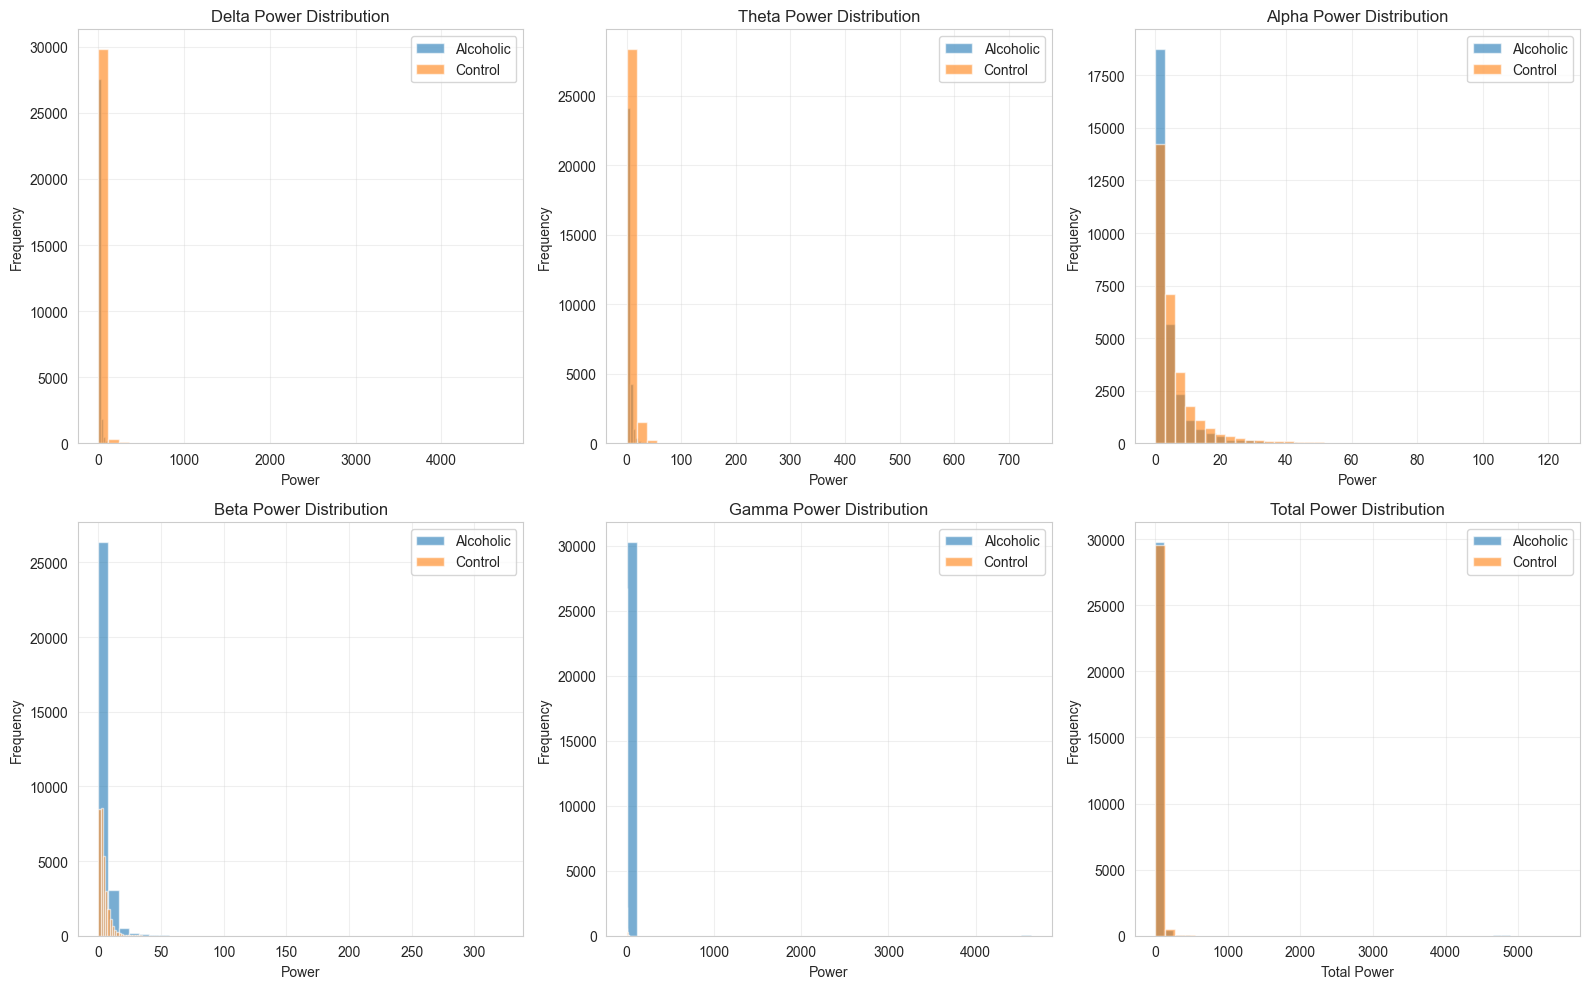

In [26]:
# Histograms
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, band in enumerate(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']):
    alcoholic = features_clean[features_clean['group'] == 'alcoholic'][band]
    control = features_clean[features_clean['group'] == 'control'][band]

    axes[idx].hist(alcoholic, bins=40, alpha=0.6, label='Alcoholic')
    axes[idx].hist(control, bins=40, alpha=0.6, label='Control')
    axes[idx].set_title(f'{band} Power Distribution')
    axes[idx].set_xlabel('Power')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Total power
ax_total = axes[5]
alcoholic_total = features_clean[features_clean['group'] == 'alcoholic']['total_power']
control_total = features_clean[features_clean['group'] == 'control']['total_power']

ax_total.hist(alcoholic_total, bins=40, alpha=0.6, label='Alcoholic')
ax_total.hist(control_total, bins=40, alpha=0.6, label='Control')
ax_total.set_title('Total Power Distribution')
ax_total.set_xlabel('Total Power')
ax_total.set_ylabel('Frequency')
ax_total.legend()
ax_total.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.4.2. Subject-level mean band powers

- Because each CSV file corresponds to one participant/session, we aggregated all band-power features at the file level to obtain one mean band-power vector per subject. Out of 948 total EEG files (468 train, 480 test), 485 files had sufficiently long and valid segments (≥100 samples per channel/trial) to compute reliable band-power estimates. These 485 subject-level vectors represent all participants with usable EEG recordings and were used for group-level statistical comparisons between alcoholic and control subjects.

In [27]:
file_means = (features_clean.groupby(['file_name', 'subject_type'])[bands].mean().reset_index())
file_means['group'] = file_means['subject_type'].map({'a': 'alcoholic', 'c': 'control'})
print("File-level aggregated band powers:")
file_means

File-level aggregated band powers:


,file_name,subject_type,Delta,Theta,Alpha,Beta,Gamma,total_power,group
0,Data1.csv,a,9.461831,2.333951,2.370298,7.925250,8.215180,30.306511,alcoholic
1,Data10.csv,a,27.833350,6.344914,1.461690,8.067331,6.070642,49.777926,alcoholic
2,Data100.csv,a,7.927562,5.557086,11.005558,4.834533,0.826956,30.151695,alcoholic
3,Data101.csv,a,8.562410,10.813234,17.828627,3.232597,0.582782,41.019650,alcoholic
4,Data102.csv,a,10.082405,7.074762,7.706993,2.171925,0.710419,27.746504,alcoholic
...,...,...,...,...,...,...,...,...,...
480,Data95.csv,a,3.534475,5.343037,13.630241,2.997218,0.722397,26.227369,alcoholic
481,Data96.csv,a,19.027367,3.335392,6.938771,4.287744,0.795302,34.384577,alcoholic
482,Data97.csv,a,2.785995,22.363614,31.571174,3.934325,0.685405,61.340514,alcoholic
483,Data98.csv,a,6.126827,4.833563,8.791573,2.489952,0.721421,22.963336,alcoholic


In [28]:
print("File-level Statistical Comparison:")
for band in bands:
    a_vals = file_means[file_means['group'] == 'alcoholic'][band]
    c_vals = file_means[file_means['group'] == 'control'][band]
    t_stat, p_val = stats.ttest_ind(a_vals, c_vals, equal_var=False)
    print(f"{band:12s}: t={t_stat:8.3f}, p={p_val:.6f} {'*' if p_val < 0.05 else ''}")

File-level Statistical Comparison:
Delta       : t=  -7.900, p=0.000000 *
Theta       : t=  -8.063, p=0.000000 *
Alpha       : t=  -3.383, p=0.000774 *
Beta        : t=   1.647, p=0.100297 
Gamma       : t=   6.390, p=0.000000 *
total_power : t=  -1.053, p=0.293076 


- Subject-level statistical analysis revealed significant differences in multiple EEG frequency bands between alcoholic and control participants. Alcoholic participants exhibited significantly lower Delta and Theta power (p < 1e-6), consistent with known deficits in low-frequency EEG activity associated with alcohol dependence. Alpha band power also differed significantly (p < 0.001), while Beta band power did not show meaningful group differences. Gamma power was significantly higher in alcoholic participants (p < 1e-6). Total band power did not differ significantly between groups. These findings support the presence of robust and physiologically interpretable spectral alterations in alcoholic EEG, validating their use for subsequent synthetic data generation.

## 2.5. Correlation Analysis (Band power & Spatial) on full data 

### 2.5.1. Frequency band correlation

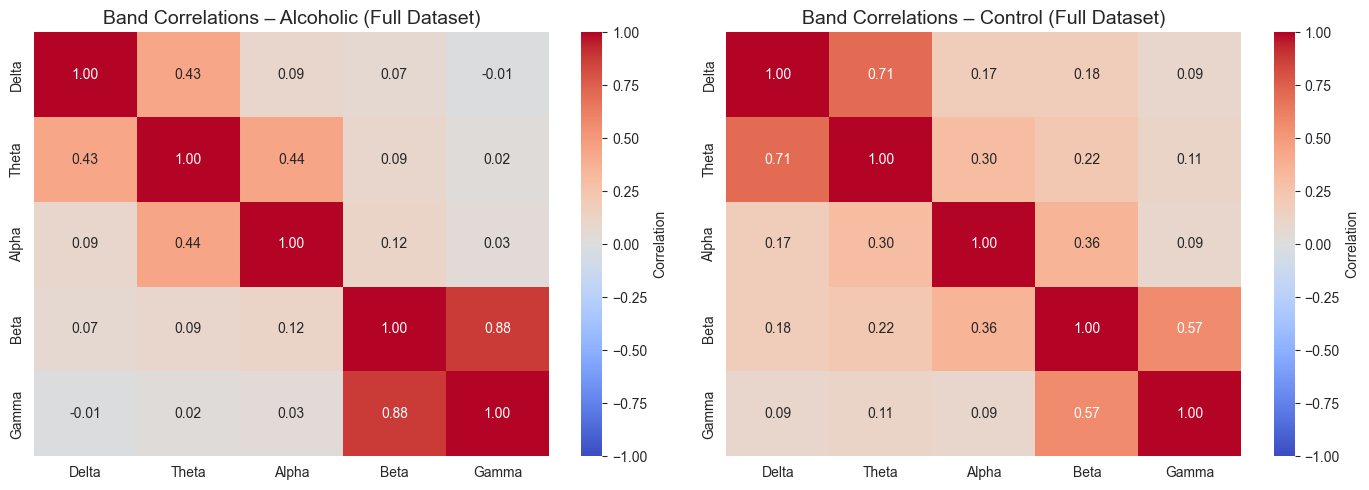

In [29]:
# FREQUENCY BAND CORRELATIONS (a vs c, full dataset)
band_columns = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

alcoholic_features = features_clean[features_clean['group'] == 'alcoholic'][band_columns]
control_features = features_clean[features_clean['group'] == 'control'][band_columns]

corr_alcoholic = alcoholic_features.corr()
corr_control = control_features.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(corr_alcoholic, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1,
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Band Correlations – Alcoholic (Full Dataset)', fontsize=14)

sns.heatmap(corr_control, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Band Correlations – Control (Full Dataset)', fontsize=14)

plt.tight_layout()
plt.show()

### 2.5.2. Correlation Difference Matrix: How connectivity between frequency bands differs between groups
- If values are positive: Alcoholics show stronger band-band coordination.
- If negative: Alcoholics show reduced coupling between those frequency bands.

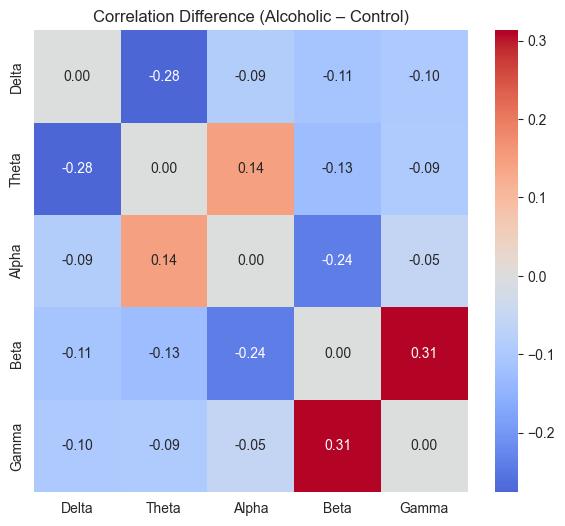

In [30]:
corr_diff = corr_alcoholic - corr_control

plt.figure(figsize=(7,6))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Difference (Alcoholic – Control)")
plt.show()

### 2.5.3. Per-Subject correlation strength (Mean Absolute Correlation)

In [31]:
def mean_abs_corr(corr):
    return np.mean(np.abs(corr.values[np.triu_indices_from(corr.values, k=1)]))

mac_alc = mean_abs_corr(corr_alcoholic)
mac_ctl = mean_abs_corr(corr_control)

print("Mean Absolute Correlation:")
print(f"Alcoholic: {mac_alc:.4f}")
print(f"Control: {mac_ctl:.4f}")


Mean Absolute Correlation:
Alcoholic: 0.2175
Control: 0.2785


### 2.5.4. Cluster-Level Correlation (K-Means)

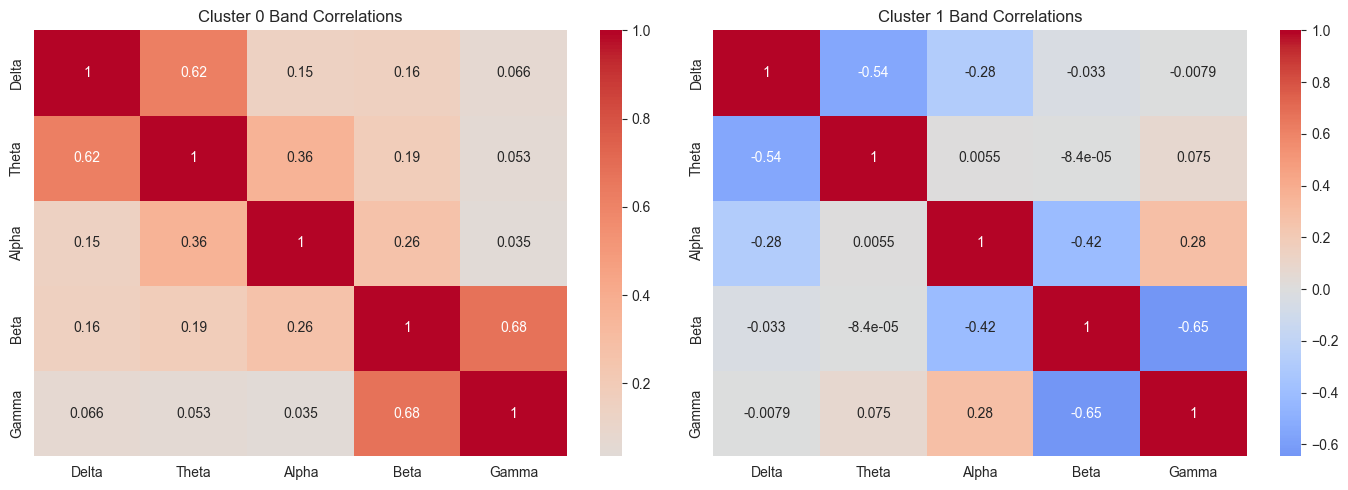

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_clean[band_columns])

features_clean["cluster"] = labels

corr_cluster0 = features_clean[features_clean["cluster"] == 0][band_columns].corr()
corr_cluster1 = features_clean[features_clean["cluster"] == 1][band_columns].corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(corr_cluster0, annot=True, cmap="coolwarm", center=0, ax=axes[0])
sns.heatmap(corr_cluster1, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[0].set_title("Cluster 0 Band Correlations")
axes[1].set_title("Cluster 1 Band Correlations")
plt.tight_layout()
plt.show()

### 2.5.4. Correlation-to-Feature Importance

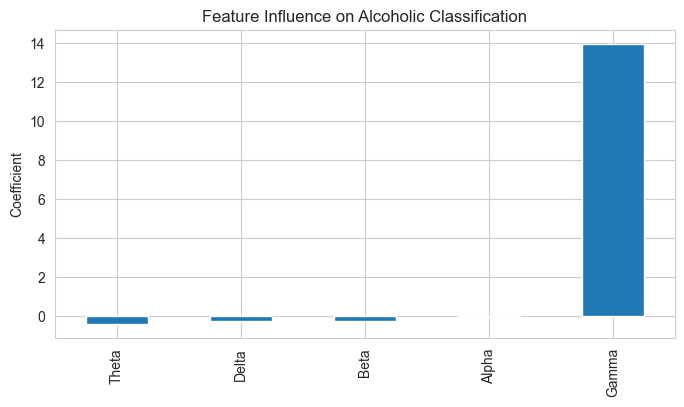

In [33]:
X = features_clean[band_columns]
y = (features_clean['group'] == 'alcoholic').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_scaled, y)

feature_importance = pd.Series(clf.coef_[0], index=band_columns)
feature_importance.sort_values().plot(kind="bar", figsize=(8,4))
plt.title("Feature Influence on Alcoholic Classification")
plt.ylabel("Coefficient")
plt.show()

## 2.6. Save Features for Synthetic Generation

In [34]:
# Segment-level features (all segments across train+test, a+c)
segment_fp_csv  = OUTPUT_DIR / "band_features_segments.csv"
segment_fp_pkl  = OUTPUT_DIR / "band_features_segments.pkl"

features_df.to_csv(segment_fp_csv, index=False)
features_df.to_pickle(segment_fp_pkl)

print(f"Saved segment-level features to:")
print(f"CSV: {segment_fp_csv}")
print(f"PKL: {segment_fp_pkl}")

Saved segment-level features to:
CSV: ../output/band_extraction/band_features_segments.csv
PKL: ../output/band_extraction/band_features_segments.pkl


In [35]:
# Subject-level mean band powers (one row per file/subject)
subject_fp_csv = OUTPUT_DIR / "band_features_subject_means.csv"
subject_fp_pkl = OUTPUT_DIR / "band_features_subject_means.pkl"

file_means.to_csv(subject_fp_csv, index=False)
file_means.to_pickle(subject_fp_pkl)

print(f"Saved subject-level mean band powers to:")
print(f"CSV: {subject_fp_csv}")
print(f"PKL: {subject_fp_pkl}")

Saved subject-level mean band powers to:
CSV: ../output/band_extraction/band_features_subject_means.csv
PKL: ../output/band_extraction/band_features_subject_means.pkl
